## Section One: Preloading required modules and linking to Google Drive for raw dataset and subsequent uploading

In [ ]:
import os
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
import shutil
import matplotlib.pyplot as plt
import numpy as np
import skimage  
import cv2 as cv
import matplotlib.image as mpimg
import os
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras import layers
from keras import models
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
print('Please copy pathway where python file, image and annotation folders have been uploaded')
dir_cnn = input()

In [ ]:
dir_cnn

'/content/drive/MyDrive/Colab Notebooks/DL/Mabrouka/Assignment/Assignment 1/root/Master'

## Section Two: Building required directory framework and image labelling

In [ ]:
images = dir_cnn + '/images'
originals = dir_cnn + '/originals'
originals_sq = dir_cnn + '/originals_square'
images_path = Path(dir_cnn + '/images/')
anno_path = Path(dir_cnn + '/annotations')

In [ ]:
images_path

In [ ]:
os.mkdir(dir_cnn + '/originals/')
os.mkdir(dir_cnn + '/originals_square/')

In [ ]:
rated = dir_cnn + '/images/originals/rated'
finished = dir_cnn + '/images/originals/finished_train_validation_test'

In [ ]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [ ]:
def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot() # module implements a simple and efficient API for parsing and creating XML
        anno = {}
        anno['link'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['folder'] = Path(str(images_path) + '/')
        anno['filename'] = root.find("./filename").text
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['Class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [ ]:
df = generate_train_df(anno_path)
df.head()

In [ ]:
df['Class'].value_counts()

speedlimit      22
trafficlight     6
crosswalk        3
stop             2
Name: Class, dtype: int64

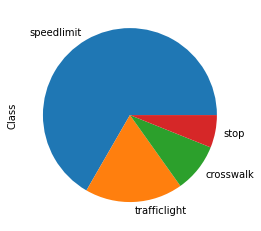

In [ ]:
df['Class'].value_counts().plot(kind='pie')
plt.savefig("Image Class Distribution.jpg")

In [ ]:
#label encode target- creating dict data type the keys are the class value and the value are the num encoder 
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

In [ ]:
# coding the class column with a numerical value 
df['Class'] = df['Class'].apply(lambda x:  class_dict[x])

In [ ]:
df.head(4)

In [ ]:
df['width'] = df['width'].astype(int)
df['height'] = df['height'].astype(int)
df['aspect_ratio'] = df['width'] / df['height']

In [ ]:
df['width'].value_counts()

300    24
400     5
267     2
320     2
Name: width, dtype: int64

In [ ]:
df['height'].value_counts()

400    28
267     4
385     1
Name: height, dtype: int64

In [ ]:
df['aspect_ratio'].value_counts()

0.750000    24
1.498127     4
0.667500     2
0.800000     2
1.038961     1
Name: aspect_ratio, dtype: int64

In [ ]:
df['Class'] = df['Class'].astype(str)
df['filename_new'] = df[["Class", "filename"]].apply(" ".join, axis=1)

In [ ]:
df.head(60)

## Section Three - Labelling images and saving to labelled folders



In [ ]:
images_path

In [ ]:
images

In [ ]:
os.chdir(images_path)
names_dict = dict(zip(df['filename_new'], df['filename']))

for new_name, old_name in names_dict.items():
    os.rename(old_name, new_name)

In [ ]:
originals

In [ ]:
import os
import shutil
dest = originals
src = images +'/' # mind the '/' at the end
[shutil.copy(src+fn, dest) for fn in os.listdir(src)]

In [ ]:
import os
import shutil
dest = originals_sq
src = images +'/' # mind the '/' at the end
[shutil.copy(src+fn, dest) for fn in os.listdir(src)]

In [ ]:
dir_cnn

In [ ]:
os.mkdir(dir_cnn + '/originals/r')
os.mkdir(dir_cnn + '/originals/0')
os.mkdir(dir_cnn + '/originals/1')
os.mkdir(dir_cnn + '/originals/2')
os.mkdir(dir_cnn + '/originals/3')

In [ ]:
# adapted https://stackoverflow.com/questions/49837143/move-files-on-respective-folder-based-on-first-char-python
path = originals
for file in os.listdir(path):
    full_path = path + '/' + file
    destination = path + '/' + file[0] + '/' + file
    os.rename(full_path, destination) #move from mixed to folder w/ same first char

### Error expected as the os.rename is trying to move the folder '0'. All images are successfully moved

## Section Four: Creating directory structure for train / val / test split and automated random file allocation

In [ ]:
#remove images with no associated xml file
shutil.rmtree(dir_cnn + '/originals/r')

In [ ]:

os.mkdir(dir_cnn + '/originals/finished_train_validation_test')

In [ ]:

os.mkdir(dir_cnn + '/originals/rated')
os.mkdir(dir_cnn + '/originals/rated/0')
os.mkdir(dir_cnn + '/originals/rated/1')
os.mkdir(dir_cnn + '/originals/rated/2')
os.mkdir(dir_cnn + '/originals/rated/3')

In [ ]:
###alternative
orig_0 = originals + '/0'
orig_rated_0 = originals + '/rated/0'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_0
trg = orig_rated_0
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
### Alternative
orig_1 = originals + '/1'
orig_rated_1 = originals + '/rated/1'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_1
trg = orig_rated_1
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
### Alternative
orig_2 = originals + '/2'
orig_rated_2 = originals + '/rated/2'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_2
trg = orig_rated_2
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
### Alternative
orig_3 = originals + '/3'
orig_rated_3 = originals + '/rated/3'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_3
trg = orig_rated_3
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
shutil.rmtree(orig_1)
shutil.rmtree(orig_2)
shutil.rmtree(orig_3)
shutil.rmtree(orig_0)

In [ ]:
#https://pypi.org/project/split-folders/
# split rated images into train, validate, test
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
rated = originals + '/rated'
finished = originals + '/finished_train_validation_test'
#https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93
import splitfolders
splitfolders.ratio(rated, output=finished,
    seed=42, ratio=(.7, .3), group_prefix=None, move=False) # default values

Copying files: 21 files [00:00, 38.67 files/s]


####Once completed the following file structure was visualised

In [ ]:
#adapted: https://www.adamsmith.haus/python/answers/how-list-a-directory-in-a-tree-structure-in-python

path = originals
for dirpath, dirnames, filenames in os.walk(path):
    directory_level = dirpath.replace(path, "")
    directory_level = directory_level.count(os.sep)
    indent = " " * 4
    print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

originals/
    finished_train_validation_test/
        train/
            0/
            1/
            2/
            3/
        val/
            0/
            1/
            2/
            3/
    rated/
        0/
        1/
        2/
        3/


In [ ]:
### Repeat for Square

###### Images edited to be the same size (using padding) reducing any features being changed when the pre-processing changes images to a square shape. The max width and heights are 400 pixels so all images will be made this size with original images centred within the padding where needed. 

In [ ]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [ ]:
#adapted https://stackoverflow.com/questions/55029388/take-an-image-directory-and-resize-all-images-in-the-directory
#adapted https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/#:~:text=If%20you%20want%20to%20resize,processing%20library%20Pillow%20(PIL)

from PIL import Image
import os
images_dir_path= originals_sq

def image_rescaling(path):
    for img in os.listdir(path):
        img_dir=os.path.join(path,img)
        img = Image.open(img_dir)
        img = expand2square(img, (255, 0, 255)).resize((64, 64))
        img.save(img_dir)
image_rescaling(images_dir_path)

In [ ]:
os.mkdir(dir_cnn + '/originals_square/r')
os.mkdir(dir_cnn + '/originals_square/0')
os.mkdir(dir_cnn + '/originals_square/1')
os.mkdir(dir_cnn + '/originals_square/2')
os.mkdir(dir_cnn + '/originals_square/3')

In [ ]:
# adapted https://stackoverflow.com/questions/49837143/move-files-on-respective-folder-based-on-first-char-python
path = originals_sq
for file in os.listdir(path):
    full_path = path + '/' + file
    destination = path + '/' + file[0] + '/' + file
    os.rename(full_path, destination) #move from mixed to folder w/ same first char

### Error expected as the os.rename is trying to move the folder '0'. All images are successfully moved

In [ ]:
os.mkdir(dir_cnn + '/originals_square/finished_train_validation_test')
os.mkdir(dir_cnn + '/originals_square/rated')
os.mkdir(dir_cnn + '/originals_square/rated/0')
os.mkdir(dir_cnn + '/originals_square/rated/1')
os.mkdir(dir_cnn + '/originals_square/rated/2')
os.mkdir(dir_cnn + '/originals_square/rated/3')

In [ ]:
shutil.rmtree(dir_cnn + '/originals_square/r')

In [ ]:

orig_0 = originals_sq + '/0'
orig_rated_0 = originals_sq + '/rated/0'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_0
trg = orig_rated_0
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
orig_1 = originals_sq + '/1'
orig_rated_1 = originals_sq + '/rated/1'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_1
trg = orig_rated_1
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
orig_2 = originals_sq + '/2'
orig_rated_2 = originals_sq + '/rated/2'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_2
trg = orig_rated_2
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
orig_3 = originals_sq + '/3'
orig_rated_3 = originals_sq + '/rated/3'
# importing required packages
from pathlib import Path
import shutil
import os
 
# defining source and destination
# paths
src = orig_3
trg = orig_rated_3
 
files=os.listdir(src)
 
# iterating over all the files in
# the source directory
for fname in files:
     
    # copying the files to the
    # destination directory
    shutil.copy2(os.path.join(src,fname), trg)

In [ ]:
shutil.rmtree(orig_1)
shutil.rmtree(orig_2)
shutil.rmtree(orig_3)
shutil.rmtree(orig_0)

In [ ]:
rated = originals_sq + '/rated'
finished = originals_sq + '/finished_train_validation_test'
#https://medium.com/nerd-for-tech/easily-split-your-directory-into-train-validation-and-testing-format-f1359f34dd93
import splitfolders
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(rated, output=finished,
    seed=42, ratio=(.7, .3), group_prefix=None, move=False) # default values

Copying files: 24 files [00:00, 49.35 files/s]


####Once completed the following file structure was visualised

In [ ]:
path = originals_sq
for dirpath, dirnames, filenames in os.walk(path):
    directory_level = dirpath.replace(path, "")
    directory_level = directory_level.count(os.sep)
    indent = " " * 4
    print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

originals_square/
    finished_train_validation_test/
        train/
            0/
            1/
            2/
            3/
        val/
            0/
            1/
            2/
            3/
    rated/
        0/
        1/
        2/
        3/


## Section Five: Creating custom model as base to explore effect of parameter selection and fine tuning

In [ ]:
#utilise if need to repeat model
#tf.keras.backend.clear_session()
#del model

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
image_size = 64,64

In [ ]:
images

'/content/drive/MyDrive/Colab Notebooks/DL/Mabrouka/Assignment/Assignment 1/root/Master/images'

In [ ]:
#adapted https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060
train_dir = originals_sq + '/finished_train_validation_test/train'
valid_dir = originals_sq+ '/finished_train_validation_test/val'



In [ ]:
train_datagen = ImageDataGenerator(    featurewise_std_normalization=False,
    samplewise_std_normalization=True,                 rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',

)
# rescale = 1./255
valid_datagen = ImageDataGenerator(    featurewise_std_normalization=False,
    samplewise_std_normalization=True,   )




train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    batch_size=16,
                                                   
)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=image_size,
                                                    class_mode="categorical",
                                                    shuffle=True,                                                    
                                                    batch_size=16,
)




Found 15 images belonging to 4 classes.
Found 9 images belonging to 4 classes.


In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = keras.models.Sequential([
    #keras.layers.Cropping2D(cropping=((0, 0), (0, 0)),  input_shape=[128,128,3]),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',  input_shape=[64,64,3]),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',),

    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Dropout(rate=0.25),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),

    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Dropout(rate=0.25),                              
    keras.layers.Flatten(),

    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(4, activation ='softmax')
])

In [ ]:
opt = keras.optimizers.Nadam(learning_rate=0.001)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20,restore_best_weights=True)


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

In [ ]:
history = model.fit(train_generator,validation_data = valid_generator,epochs=50, verbose=1, callbacks = callback)

In [ ]:
loss, accuracy = model.evaluate(valid_generator,batch_size=64)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

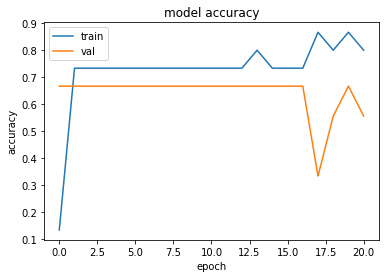

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('1.png')

## Section Six: Pretrained model utilisation and fine tuning

In [ ]:
tf.keras.backend.clear_session()
del model

In [ ]:


seed = 1842
tf.random.set_seed(seed)
np.random.seed(seed)

image_size = 64,64

orig_sq = images +'/originals_square'
train_dir = orig_sq + '/finished_train_validation_test/train'
valid_dir = orig_sq + '/finished_train_validation_test/val'

train_datagen = ImageDataGenerator(    featurewise_std_normalization=False,
    samplewise_std_normalization=True,                 rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',

)
# rescale = 1./255
valid_datagen = ImageDataGenerator(    featurewise_std_normalization=False,
    samplewise_std_normalization=True,   )




train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    batch_size=16,
                                                   
)

valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=image_size,
                                                    class_mode="categorical",
                                                    shuffle=False,                                                    
                                                    batch_size=16,
)


In [ ]:
#adapted https://keras.io/api/applications/efficientnet/#efficientnetb7-function
#chosen as https://keras.io/api/applications/ Top 1 / Top5 Accuracy Improvement on Custom
from keras.api._v2.keras.applications import VGG19
from tensorflow.keras.models import Model

EfficientNetB7 = keras.applications.EfficientNetB7(
    
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,

  #input_shape = (50,50,3),
)

conv_base = EfficientNetB7
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(Flatten()) 
model.add(Dense(256,activation=('relu')))

model.add(Dense(4,activation=('softmax'))) 

In [ ]:
#hybrid model
#adapted https://keras.io/api/applications/efficientnet/#efficientnetb7-function
#chosen as https://keras.io/api/applications/ Top 1 / Top5 Accuracy Improvement on Custom
from keras.api._v2.keras.applications import VGG19
from tensorflow.keras.models import Model

EfficientNetB7 = keras.applications.EfficientNetB7(
    
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    #input_shape=None,
    pooling=None,
    classes=1000,

  input_shape = (64,64,3),
)

conv_base = EfficientNetB7
conv_base.trainable = True
model = models.Sequential()
model.add(conv_base)
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',  padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2),  padding="same"))
model.add(Dropout(rate=0.5))
model.add(Flatten()) 
model.add(Dense(256,activation='relu'))
model.add(Dense(4,activation='softmax')) 





In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=20,restore_best_weights=True,)
print(model.summary())                                         

In [ ]:
history = model.fit(train_generator,validation_data = valid_generator,epochs=50, verbose=1, callbacks = callback)

In [ ]:
loss, accuracy = model.evaluate(valid_generator,batch_size=64)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
